# Challenge 2: Recommendation Engine for Prime Video

# Imports

In [1]:
import keras
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
% matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
% load_ext autoreload
% autoreload 2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Data

In [2]:
# Load video counts. Sort by video ID & date
video_data = pd.read_csv('data/challenge_2/video_count.csv')
video_data = video_data.sort_values(by=['video_id', 'date'])
video_data = video_data.reset_index(drop=True)
print(video_data.shape)

# Load video features. Sort by video ID
video_features = pd.read_csv('data/challenge_2/video_features.csv')
video_features = video_features.sort_values(by=['video_id'])
video_features = video_features.reset_index(drop=True)
print(video_features.shape)

print('\n')
print(video_data.head(3))
print('\n')
print(video_features.head(3))

(41775, 3)
(2785, 5)


   video_id  counts        date
0         1  140460  2015-01-01
1         1  129082  2015-01-02
2         1  120868  2015-01-03


   video_id  video_length video_language video_upload_date video_quality
0         1          1496             Es        2014-12-04          720p
1         2           751             Cn        2014-12-14          480p
2         3           807             En        2014-12-15         1080p


### Data Information

In [3]:
total_samples = video_data.counts.shape[0]
num_days = np.unique(video_data['date']).shape[0]
num_vids = int(total_samples / num_days)

print('%d total samples' % total_samples)
print('%d different days' % num_days)
print('%d different videos' % num_vids)

41775 total samples
15 different days
2785 different videos


## Group counts to video_id

In [4]:
counts = np.zeros((num_vids, num_days))
video_id = np.zeros((num_vids, 1))

for vid_id in range(num_vids):
    counts[vid_id, :] = video_data['counts'][(vid_id*num_days) : (vid_id+1)*num_days]
    video_id[vid_id, 0] = video_data['video_id'][(vid_id*num_days)]
    
print('Video counts: ', counts.shape)
print('    Video ID: ', video_id.shape)

Video counts:  (2785, 15)
    Video ID:  (2785, 1)


## Normalise data

In [5]:
counts_norm = np.zeros(counts.shape)

for i in range(num_vids):
    counts_norm[i,:] = counts[i,:] / counts[i,0]
    
print('Normalised data shape: ', counts_norm.shape)

Normalised data shape:  (2785, 15)


# Clustering

## Classify 'Hot' Videos

In [174]:
from sklearn.cluster import KMeans

kmeans1 = KMeans(n_clusters=2, tol=1e2, init='random', random_state=0).fit(counts_norm)
dict1 = {i: np.where(kmeans1.labels_ == i)[0] for i in range(kmeans1.n_clusters)}

In [175]:
if np.mean(counts_norm[dict1[0]]) > np.mean(counts_norm[dict1[1]]):
    hot_idx = dict1[0]
    other_idx = dict1[1]
    labels = ['Hot', 'Other']
else:
    hot_idx = dict1[1]
    other_idx = dict1[0]
    labels = ['Other', 'Hot']

print('"Hot" videos: ', hot_idx.shape[0])
print('Other videos: ', other_idx.shape[0])

"Hot" videos:  463
Other videos:  2322


Hot:    Norm: 30.25    Count: 85810
Other:    Norm:  0.87    Count: 731759


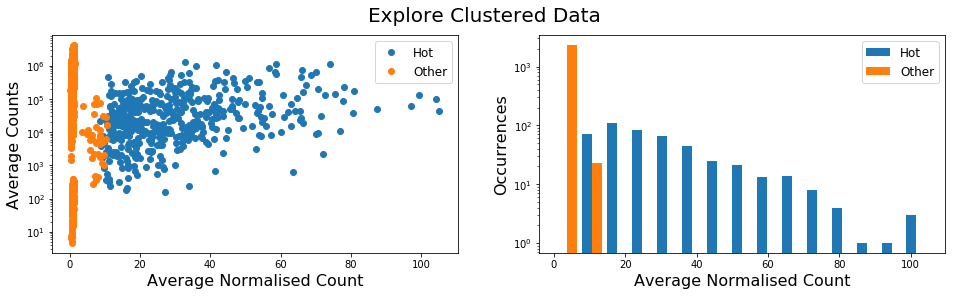

In [184]:
from utils.utils import*

plot(kmeans1, counts, counts_norm, dict1, labels)

## Classify Stable & Popular vs. Everything Else

In [ ]:
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(counts[other_idx])
dict2 = {i: np.where(kmeans2.labels_ == i)[0] for i in range(kmeans2.n_clusters)}

In [ ]:
if np.mean(counts[other_idx][dict2[0]]) > np.mean(counts[other_idx][dict2[1]]):
    popular_idx = dict2[0]
    else_idx = dict2[1]
else:
    popular_idx = dict2[1]
    else_idx = dict2[0]

In [ ]:
# Plot the results
plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
for i in set(kmeans2.labels_):
    index = kmeans2.labels_ == i
    plt.plot(np.mean(counts_norm[other_idx][index, :], axis=1), np.mean(counts[other_idx][index, :], axis=1), 'o', label=str(i))
    print('Cluster %d:    Norm: %5.2f    Count: %.0f' % (i, np.mean(counts_norm[other_idx][dict2[i]]), np.mean(counts[other_idx][dict2[i]])))
plt.legend()

# plt.subplot(1, 2, 2)
# concat = np.concatenate((np.mean(counts_norm[dict1[0]], axis=1), np.mean(counts_norm[dict1[1]], axis=1)), axis=0)
# print(concat.shape)
# plt.hist(concat, histtpe='bar', bins=100)
# # plt.hist(np.mean(counts_norm[dict1[0]], axis=1), histtpe='bar', bins=100)
# plt.show()


plt.subplot(1, 2, 2)
a = list(np.mean(counts[other_idx][dict2[0]], axis=1))
b = list(np.mean(counts[other_idx][dict2[1]], axis=1))
c = [a,b]
plt.hist(c, histtype='bar', bins=5)
plt.show()

# Classifications

In [ ]:
## Hot videos
video_id[hot_idx][:5]

In [ ]:
## Stable & Popular videos
video_id[popular_idx][:5]

In [ ]:
## Everything Else
video_id[else_idx][:5]

## Characteristics of "Hot" Videos

In [ ]:
hot_idx

In [ ]:
plt.hist(video_features['video_length'][hot_idx])

In [ ]:
video_features['video_language'][hot_idx] == 'Cn'

In [ ]:
# Cn = video_features['video_language'][hot_idx] == 'Cn'
# De
En_idx = video_features['video_language'][hot_idx] == 'En'
# Es
# Fr
# Other

In [ ]:
video_features['video_language'][hot_idx][En_idx]

In [ ]:
languages = np.unique(video_features['video_language'][hot_idx])
languages

In [ ]:
for l in range(languages):
    